In [3]:
# Stylianos Topalidis
# AEM: 9613
# email: styltopa@ece.auth.gr 

In [4]:
from sklearn import datasets, tree
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

# if the import below does not work please try opening a terminal and writing 
# pip install -U scikit-learn --user
# this worked for me at least in vscode.
# There is some discourse in the forum that it does not work in collab
# see https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
from sklearn.inspection import DecisionBoundaryDisplay



In [5]:
# Part A

# Load the data
iris = datasets.load_iris()


# First attribute: sepal length (cm)
# Second attribute: sepal width (cm)
irisData = iris.data[:, 0:2]

# Fields of iris data object
# ['DESCR', 'data', 'data_module', 'feature_names', \
#  'filename', 'frame', 'target', 'target_names']

# Percentage of the data for the training 
trainPercent = 0.5


# Turn the target values into a set of all possible targets {0, 1, 2} 
# to exclude duplicates (multiple 0, 1 and 2)
targetSet = set(iris.target)
# Turn the set into a list and then into a numpy array
# for convenience 
targetList = list(targetSet)
targetArr = np.array(targetList) 



# Indexes for all the data samples (iterates over the data 
# for the different targets: setosa, versicolor, virginica) 
indsPerKind = []
# Indexes for the training and testing data in the original dataset
trainingInds = []
testingInds = []


# For each of the flower kinds
for targetCount in range(len(targetArr)):
    indexesArr = np.where(iris.target == targetCount)

    # the first element of the list are the actual data 
    # and the second one is its data type 
    indsPerKind = list(indexesArr[0])

    # number of training data derived from the training percentage selected
    # per group identifier (0, 1, 2)
    numOfTrainingDataPerIdentifier = round(trainPercent*len(indsPerKind))
    numOfTestingDataPerIdentifier = len(indsPerKind) - numOfTrainingDataPerIdentifier

    # concatenate the indices of the new target (identifier) training data 
    # with the indices of the old target training data.
    trainingInds = trainingInds + indsPerKind[0:numOfTrainingDataPerIdentifier]
    testingInds = testingInds + indsPerKind[numOfTrainingDataPerIdentifier:]
    

# list -> np.array
trainingInds = np.array(trainingInds)
testingInds = np.array(testingInds)

# To avoid training the tree with batches of data of the same target,
# as given (all setosa first, then all versicolor and finally all virginica),
# we permute the training data
np.random.seed(0)
trainingIndsPerm =  np.random.permutation(trainingInds)

# Training data and target values
trainingArr = irisData[trainingIndsPerm]
targetArrTraining = iris.target[trainingIndsPerm]

# Testing data and target values
testingArr = irisData[testingInds]
targetArrTesting = iris.target[testingInds]


# A.1
print('Classification accuracy')
# tree depths
treeDepths = np.array([3, 4, 5])
for depthCount in treeDepths:
    # Classifier training
    clf = tree.DecisionTreeClassifier(max_depth=depthCount)
    clf = clf.fit(trainingArr, targetArrTraining)
    
    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)


    # number of correctly predicted target values
    correctlyPredicted = 0

    numOfTrainingData = len(targetSet)*numOfTrainingDataPerIdentifier


    targetAndPred = np.stack((targetArrTesting, targetArrPred), axis=1) 

    for predCount in range(numOfTrainingData):
        if targetArrTesting[predCount] == targetArrPred[predCount]: 
            # print(targetAndPred[predCount])
            correctlyPredicted = correctlyPredicted + 1
        # else:
            # print(targetAndPred[predCount])


    accuracy = correctlyPredicted/numOfTrainingData
    # print(correctlyPredicted)
    # print(numOfTrainingData)
    print('For decision tree depth = ', depthCount, ': ', round(accuracy*100, 2), '%')
    if depthCount == treeDepths[0]:
        maxAccClf = clf
        maxAcc = accuracy
    if maxAcc < accuracy:
        maxAccClf = clf
        maxAcc = accuracy

print('\nMax accuracy classifier was the one with depth = ', maxAccClf.tree_.max_depth, \
    'and accuracy: ', round(100*maxAcc, 2), '%')



Classification accuracy
For decision tree depth =  3 :  69.33 %
For decision tree depth =  4 :  80.0 %
For decision tree depth =  5 :  78.67 %

Max accuracy classifier was the one with depth =  4 and accuracy:  80.0 %


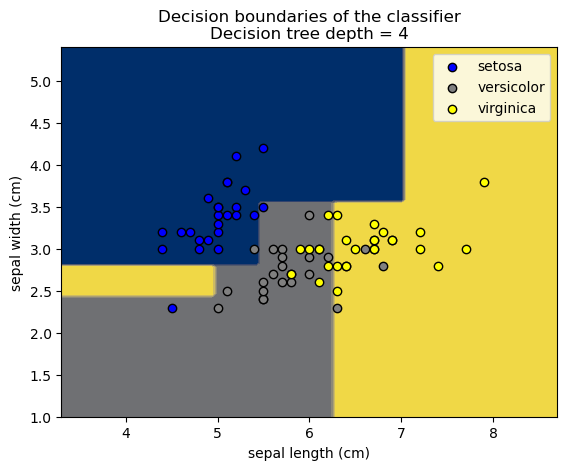

In [6]:
# A.2
# function to display the decision boundaries
display = DecisionBoundaryDisplay.from_estimator(
    maxAccClf, trainingArr,  cmap=plt.cm.cividis, response_method="predict",
    xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],
    plot_method= 'contourf'
)

# print(targetArrTesting)

c  = ['blue', 'grey', 'yellow']

for counter, target in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == target)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color=c[counter], edgecolor="black", label = iris.target_names[counter]
    )

display.ax_.set_title('Decision boundaries of the classifier\nDecision tree depth = ' \
    + str(maxAccClf.tree_.max_depth))

plt.legend()

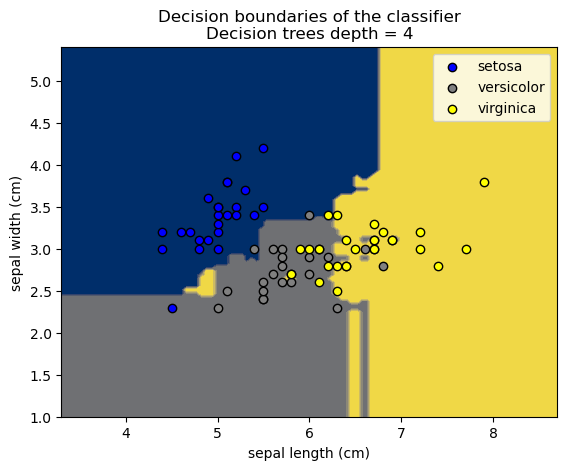

In [20]:
# Part B
import random 
import math

# Create B = 100 bootstrap samples of n = 25 observations of (sepal length, sepal width) per target value.

# Number of trees in the forest
B = 100
# Percentage of the original training data in the bootstrap samples
gamma = 0.8
# Number of elements per bootstrap sample
bootSamNumOfElem = round(gamma*numOfTrainingData)


from sklearn.ensemble import RandomForestClassifier

# number of estimators
B = 100
depth = 4
clf = RandomForestClassifier(n_estimators=B, max_depth=depth, bootstrap=True, max_samples=bootSamNumOfElem)
clf = clf.fit(trainingArr, targetArrTraining)

display = DecisionBoundaryDisplay.from_estimator(
    clf, trainingArr,  cmap=plt.cm.cividis, response_method="predict",
    xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],
    plot_method= 'contourf'
)

c  = ['blue', 'grey', 'yellow']

for counter, target in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == target)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color=c[counter], edgecolor="black", label = iris.target_names[counter]
    )

display.ax_.set_title('Decision boundaries of the classifier\nDecision trees depth = ' \
    + str(depth))

plt.legend()

In [ ]:


# 1) create the trees (B in number) - ok
# 2) merge their decisions (committee decision) according to the theory (11th lecture) and
# according to online sources
# - use https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html#sphx-glr-auto-examples-ensemble-plot-forest-iris-py 
# 
# 3) get the accuracy percent and print it
# 4) Get the forest accuracy. Do the same for multiple tree depths (all trees in a forest must have the same depths)
# 5) Find the tree depth giving the forest with the best accuracy